In [10]:
# @title Imports and Global Variables  { display-mode: "form" }
# !pip3 install -q observations
from __future__ import absolute_import, division, print_function

# @markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore"  # @param ["ignore", "always", "module", "once", "default", "error"]
import warnings

warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import math
import numpy as np
import string
from datetime import datetime
import os

# @markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
# matplotlib_style = 'default'  # @param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt;

# plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
# @markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
import seaborn as sns;

# sns.set_context('notebook')
# from IPython.core.pylabtools import figsize

import tensorflow as tf

tfe = tf.contrib.eager

# Eager Execution
# @markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
# @markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False  # @param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors


def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.

    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)


class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'

    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]


TFColor = _TFColor()


def session_options(enable_gpu_ram_resizing=False, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)


reset_sess()

# from edward.models import Categorical, Mixture, Normal
from scipy import stats
from sklearn.model_selection import train_test_split


# import params
# https://github.com/cbonnett/MDN_Edward_Keras_TF/blob/master/MDN_Edward_Keras_TF.ipynb
# http://cbonnett.github.io/MDN.html
# https://github.com/tensorflow/probability/blob/a4d1fbc131880ed3ffa83fe83b1d2583da90f294/tensorflow_probability/examples/jupyter_notebooks/Mixture_Density_Network_TFP.ipynb

################################################################


def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
  """Plots the mixture of Normal models to axis=ax comp=True plots all
  components of mixture model
  """
  # x = np.linspace(-10.5, 10.5, 250)
  x = np.linspace(-0.1, 1.1, 250)
  final = np.zeros_like(x)
  for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
    temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
    final = final + temp
    if comp:
      ax.plot(x, temp, label='Normal ' + str(i))
  ax.plot(x, final, label='Mixture of Normals ' + label)
  ax.legend(fontsize=13)

def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
  """Draws samples from mixture model.

  Returns 2 d array with input X and sample from prediction of mixture model.
  """
  samples = np.zeros((amount, 2))
  n_mix = len(pred_weights[0])
  to_choose_from = np.arange(n_mix)
  for j, (weights, means, std_devs) in enumerate(
          zip(pred_weights, pred_means, pred_std)):
    index = np.random.choice(to_choose_from, p=weights)
    samples[j, 1] = np.random.normal(means[index], std_devs[index], size=1)
    samples[j, 0] = x[j]
    if j == amount - 1:
      break
  return samples


print(20*'=~')
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(20*'=~')



n_epoch = 100 #1000 #20000 #20000
# N = 4000  # number of data points  -- replaced by num_trai
D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
K = 3 # number of mixture components


learning_rate = 5e-3


num_train = 8000 #800000
num_test = 500 #10000 #params.num_test # 32
#
datafile = ['DES', 'COSMOS', 'Galacticus', 'GalaxPy'][3]
sim_obs_combine = True

if sim_obs_combine: ModelName = './Model/Edward_posterior_cutsomLoss_' + datafile + '_nComp' + str(K) + \
                                '_ntrain' + str(num_train) + '_nepoch' + str(n_epoch) + '_lr' + \
                                str(learning_rate) + '_sim_obs_combine'
else: ModelName = './Model/Edward_posterior_customLoss_' + datafile + '_nComp' + str(K) + '_ntrain' + str(
    num_train) + '_nepoch' + str(n_epoch)  + '_lr' + str(learning_rate)  + '_obs_only'


np.random.seed(42)




=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~
=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~


In [11]:

if datafile == 'DES' :
  dirIn = '../data/'
  allfiles = ['DES.train.dat', './DES5yr.nfits.dat']

  Trainfiles = np.loadtxt(dirIn + allfiles[0])
  Testfiles = np.loadtxt(dirIn + allfiles[1])

  TrainshuffleOrder = np.arange(Trainfiles.shape[0])
  np.random.shuffle(TrainshuffleOrder)

  TestshuffleOrder = np.arange(Testfiles.shape[0])
  np.random.shuffle(TestshuffleOrder)

  Trainfiles = Trainfiles[TrainshuffleOrder]
  Testfiles = Testfiles[TestshuffleOrder]

  X_train = Trainfiles[:num_train, 2:10]  # color mag
  X_test = Testfiles[:num_test, 2:10]  # color mag

  xmax = np.max( [X_train.max(), X_test.max()] )
  xmin = np.min( [X_train.min(), X_test.min()] )

  X_train = (X_train - xmin)/(xmax - xmin)
  X_test = (X_test - xmin)/(xmax - xmin)


  y_train = Trainfiles[:num_train, 0]  # spec z
  y_test = Testfiles[:num_test, 0]  # spec z


  ymax = np.max( [y_train.max(), y_test.max()] )
  ymin = np.min( [y_train.min(), y_test.min()] )

  y_train = (y_train - ymin)/(ymax - ymin)
  y_test = (y_test - ymin)/(ymax - ymin)



if datafile == 'COSMOS' :
  dirIn = '../../Data/fromJonas/'
  allfiles = ['catalog_v0.txt', 'catalog_v1.txt', 'catalog_v2a.txt', 'catalog_v2.txt',
              'catalog_v2b.txt', 'catalog_v3.txt'][3]


  Trainfiles = np.loadtxt(dirIn + allfiles)

  TrainshuffleOrder = np.arange(Trainfiles.shape[0])
  np.random.shuffle(TrainshuffleOrder)

  Trainfiles = Trainfiles[TrainshuffleOrder]

  X_train = Trainfiles[:num_train, 2:8]  # color mag
  X_test = Trainfiles[num_train + 1: num_train + num_test, 2:8]  # color mag

  ifFlux = True
  if ifFlux:
      X_train = -2.5*np.log(X_train)
      X_test = -2.5*np.log(X_test)

  xmax = np.max( [X_train.max(), X_test.max()] )
  xmin = np.min( [X_train.min(), X_test.min()] )

  X_train = (X_train - xmin)/(xmax - xmin)
  X_test = (X_test - xmin)/(xmax - xmin)

  y_train = Trainfiles[:num_train, 0]  # spec z
  y_test = Trainfiles[num_train + 1: num_train + num_test, 0]  # spec z

  ymax = np.max( [y_train.max(), y_test.max()] )
  ymin = np.min( [y_train.min(), y_test.min()] )

  y_train = (y_train - ymin)/(ymax - ymin)
  y_test = (y_test - ymin)/(ymax - ymin)



if datafile == 'GalaxPy':
    import numpy as np
    import os
    import sys
    import glob
    from astropy.table import Table

    # path_program = os.path.dirname(os.path.dirname(os.path.realpath(__file__))) + '/'
    path_program = '../../Data/fromGalaxev/photozs/datasets/'

    class Curated_sample():
        ''' Class to store the redshift and colors of observed galaxies,
            and the redshift, Mpeak, colors, and "weights" of simulated
            galaxies whose colors are compatible with those of observed
            galaxies.

            The observed sample include galaxies from SDSS
            (SDSS+BOSS+eBOSS), DEEP2, and VIPERS.

            The simulated sample was created by sampling the parameter of
            GALAXPY using a LH.

            The weights of simulated galaxies are related to the number
            density of observed galaxies in the same region of the color
            space.

            You only have to care about the method load_structure. '''

        def __init__(self):
            self.arr_c = []
            self.arr_z = []
            self.arr_m = []
            self.arr_w = []

        def append(self, c, z, m, w):
            self.arr_c.append(c)
            self.arr_z.append(z)
            self.arr_m.append(m)
            self.arr_w.append(w)

        def ndarray(self):
            self.arr_c = np.concatenate(self.arr_c)
            self.arr_z = np.concatenate(self.arr_z)
            self.arr_m = np.concatenate(self.arr_m)
            self.arr_w = np.concatenate(self.arr_w)

        def save_struct(self, name):
            np.save(name + 'c.npy', self.arr_c)
            np.save(name + 'z.npy', self.arr_z)
            np.save(name + 'm.npy', self.arr_m)
            np.save(name + 'w.npy', self.arr_w)

        def load_struct(self, name):
            self.arr_c = np.load(name + 'c.npy')
            self.arr_z = np.load(name + 'z.npy')
            self.arr_m = np.load(name + 'm.npy')
            self.arr_w = np.load(name + 'w.npy')

        def duplicate_data(self, zrange):
            aa = np.where((self.arr_w > 50)
                          & (self.arr_z >= zrange[0])
                          & (self.arr_z < zrange[1]))[0]
            print(aa.shape)
            cc = np.repeat(aa, self.arr_w[aa].astype(int))
            self.arr_cn = self.arr_c[cc, :]
            self.arr_zn = self.arr_z[cc]
            self.arr_mn = self.arr_m[cc]


    def read_curated_data():
        run_path = path_program + 'runs/run_z3/'

        sim_q = Curated_sample()  # simulated colors quenched galaxies
        sim_s = Curated_sample()  # simulated colors star-forming galaxies
        obs_q = Curated_sample()  # observed colors quenched galaxies
        obs_s = Curated_sample()  # observed colors star-forming galaxies

        obs_q.load_struct(run_path + 'str_obs_q')
        obs_s.load_struct(run_path + 'str_obs_s')
        sim_q.load_struct(run_path + 'str_sim_q')
        sim_s.load_struct(run_path + 'str_sim_s')

        print(sim_q.arr_c.shape)
        print(sim_s.arr_c.shape)
        print(obs_q.arr_c.shape)
        print(obs_s.arr_c.shape)

        return sim_q, sim_s, obs_q, obs_s


    sim_q, sim_s, obs_q, obs_s = read_curated_data()




    if sim_obs_combine:
        train_datafile = 'GalaxPy'
        

    # 2.0 ####### TRAIN USING SIMULATION, TEST OBSERVATION ####

        Trainfiles =np.append( sim_q.arr_c, sim_s.arr_c, axis = 0)
        TrainZ = np.append( sim_q.arr_z, sim_s.arr_z, axis = 0)

        Trainfiles = np.delete(Trainfiles,(4), axis=1)   ## deleting z-Y

        Testfiles =np.append( obs_q.arr_c, obs_s.arr_c, axis = 0)
        TestZ = np.append( obs_q.arr_z, obs_s.arr_z, axis = 0)


        TrainshuffleOrder = np.arange(Trainfiles.shape[0])
        np.random.shuffle(TrainshuffleOrder)

        Trainfiles = Trainfiles[TrainshuffleOrder]
        TrainZ = TrainZ[TrainshuffleOrder]

        TestshuffleOrder = np.arange(Testfiles.shape[0])
        np.random.shuffle(TestshuffleOrder)

        Testfiles = Testfiles[TestshuffleOrder]
        TestZ = TestZ[TestshuffleOrder]


        X_train = Trainfiles[:num_train]  # color mag
        X_test = Trainfiles[:num_test]  # color mag

        y_train = TrainZ[:num_train]  # spec z
        y_test = TrainZ[:num_test]  # spec z

    else:
        train_datafile = 'SDSS'
        # 1.1 ####### SIMULATED: QUENCHED ONLY ############
        # Trainfiles = sim_q.arr_c
        # TrainZ = sim_q.arr_z

        # 1.2 ### SIMULATED: QUENCHED + STAR FORMATION ####

        # Trainfiles =np.append( sim_q.arr_c, sim_s.arr_c, axis = 0)
        # TrainZ = np.append( sim_q.arr_z, sim_s.arr_z, axis = 0)


        # 1.3 ####### OBSERVED: QUENCHED + STAR FORMATION ####

        Trainfiles =np.append( obs_q.arr_c, obs_s.arr_c, axis = 0)
        TrainZ = np.append( obs_q.arr_z, obs_s.arr_z, axis = 0)

        TrainshuffleOrder = np.arange(Trainfiles.shape[0])
        np.random.shuffle(TrainshuffleOrder)

        Trainfiles = Trainfiles[TrainshuffleOrder]
        TrainZ = TrainZ[TrainshuffleOrder]

        # 1 #################################

        X_train = Trainfiles[:num_train]  # color mag
        X_test = Trainfiles[num_train + 1: num_train + num_test]  # color mag

        X_train = Trainfiles[:num_train]  # color mag
        X_test = Trainfiles[num_train + 1: num_train + num_test]  # color mag

        y_train = TrainZ[:num_train]  # spec z
        y_test = TrainZ[num_train + 1: num_train + num_test]  # spec z



    ############## THINGS ARE SAME AFTER THIS ###########

    ## rescaling xmax/xmin
    xmax = np.max([np.max(X_train, axis = 0), np.max(X_test, axis=0)], axis = 0)
    xmin = np.min([np.min(X_train, axis = 0), np.min(X_test, axis=0)], axis = 0)

    X_train = (X_train - xmin) / (xmax - xmin)
    X_test = (X_test - xmin) / (xmax - xmin)

    #### RESCALING X_train, X_test NOT done yet -- (g-i), (r-i) ... and i mag -->> Color/Mag issue

    ymax = np.max([y_train.max(), y_test.max()])
    ymin = np.min([y_train.min(), y_test.min()])

    y_train = (y_train - ymin) / (ymax - ymin)
    y_test = (y_test - ymin) / (ymax - ymin)


print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))



PlotScatter = False

if PlotScatter:
    for ind in range(D):

        sns.regplot(X_train[:,ind], y_train, fit_reg=False, scatter_kws={'s':8})
        # sns.regplot(X_train[:,1], y_train, fit_reg=False, color='blue', scatter_kws={'s':8})
        # sns.regplot(X_train[:,2], y_train, fit_reg=False, color='green', scatter_kws={'s':8})
        # sns.regplot(X_train[:,3], y_train, fit_reg=False, color='black', scatter_kws={'s':8})
        # sns.regplot(X_train[:,4], y_train, fit_reg=False, color='orange', scatter_kws={'s':8})
        # sns.regplot(X_train[:,5], y_train, fit_reg=False, color='gray', scatter_kws={'s':8})

    plt.show()



(6304534, 6)
(7237871, 6)
(456685, 5)
(423353, 5)
Size of features in training data: (8000, 5)
Size of output in training data: (8000,)
Size of features in test data: (500, 5)
Size of output in test data: (500,)


In [12]:

######################### network arch ##############################

#
# X_ph = tf.placeholder(tf.float32, [None, D])
# y_ph = tf.placeholder(tf.float32, [None])


# def neural_network(X):
#   """loc, scale, logits = NN(x; theta)"""
#   # 2 hidden layers with 15 hidden units
#   net = tf.layers.dense(X, 15, activation=tf.nn.relu)
#   net = tf.layers.dense(net, 15, activation=tf.nn.relu)
#   locs = tf.layers.dense(net, K, activation=None)
#   scales = tf.layers.dense(net, K, activation=tf.exp)
#   logits = tf.layers.dense(net, K, activation=None)
#   return locs, scales, logits
#
#
# locs, scales, logits = neural_network(X_ph)
# # cat = ed.Categorical(logits=logits)
# cat = tfd.Categorical(logits=logits)
#
# components = [ed.Normal(loc=loc, scale=scale) for loc, scale
#               in zip(tf.unstack(tf.transpose(locs)),
#                      tf.unstack(tf.transpose(scales)))]
# y = ed.Mixture(cat=cat, components=components, value=tf.zeros_like(y_ph))
# # Note: A bug exists in Mixture which prevents samples from it to have
# # a shape of [None]. For now fix it using the value argument, as
# # sampling is not necessary for MAP estimation anyways.


def neural_network(X):
    """
    loc, scale, logits = NN(x; theta)

    Args:
      X: Input Tensor containing input data for the MDN
    Returns:
      locs: The means of the normal distributions that our data is divided into.
      scales: The scales of the normal distributions that our data is divided
        into.
      logits: The probabilities of ou categorical distribution that decides
        which normal distribution our data points most probably belong to.
    """
    # 2 hidden layers with 15 hidden units
    net = tf.layers.dense(X, 15, activation=tf.nn.relu)
    net = tf.layers.dense(net, 15, activation=tf.nn.relu)
    locs = tf.layers.dense(net, K, activation=None)
    scales = tf.layers.dense(net, K, activation=tf.exp)
    logits = tf.layers.dense(net, K, activation=None)
    return locs, scales, logits


# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())

locs, scales, logits = neural_network(tf.convert_to_tensor(X_train))
cat = tfd.Categorical(logits=logits)
components = [tfd.Normal(loc=loc, scale=scale) for loc, scale
              in zip(tf.unstack(tf.transpose(locs)),
                     tf.unstack(tf.transpose(scales)))]

y = tfd.Mixture(cat=cat, components=components)


In [13]:

# ######################### inference ##############################

# # # There are no latent variables to infer. Thus inference is concerned
# # # with only training model parameters, which are baked into how we
# # # specify the neural networks.
# # inference = ed.MAP(data={y: y_ph})
# # optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# # inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())



# # There are no latent variables to infer. Thus inference is concerned
# # with only training model parameters, which are baked into how we
# # specify the neural networks.

# log_likelihood = y.log_prob(y_train)
# log_likelihood = -tf.reduce_sum(log_likelihood)
# learning_rate = 5e-2
# optimizer = tf.train.AdamOptimizer(learning_rate)
# train_op = optimizer.minimize(log_likelihood)

# ##################################################################




In [14]:

######################### inference ##############################
# ##### custom loss trial #######

log_likelihood = y.log_prob(y_train)
# log_likelihood = -tf.reduce_sum(log_likelihood/(1. + y_train)**2 )
log_likelihood = -tf.reduce_sum(log_likelihood/(1. + y_train) )


# learning_rate = 5e-2
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(log_likelihood)

##################################################################

In [15]:

# ######################### inference ##############################
# # ##### custom loss trial #######

# log_likelihood = y.log_prob(y_train)
# # log_likelihood = -tf.reduce_sum(log_likelihood/(1. + y_train)**2 )
# log_likelihood = -tf.reduce_sum(log_likelihood/(1. + y_train) )


# learning_rate = 5e-2
# optimizer = tf.train.AdamOptimizer(learning_rate)
# train_op = optimizer.minimize(log_likelihood)

# ##################################################################

In [16]:
# ##### custom loss trial #######

# # here's the KL-Div loss, note the inputs are softmax distributions, not raw logits
# def kl_divergence(p, q):
#     return tf.reduce_sum(p * tf.log(p/q))

# loss_2 = kl_divergence(a, y_g)

# # combined loss, since the DKL loss can be negative, reverse its sign when negative
# # basically an abs() but the demonstration is on how to use tf.cond() to check tensor values
# loss_2 = tf.cond(loss_2 < 0, lambda: -1 * loss_2, lambda: loss_2)

# # can also normalize the losses for stability but not done in this case
# norm = 1 #tf.reduce_sum(loss_1 + loss_2)
# loss = loss_1 / norm + dkl_loss_rate*loss_2 / norm

# # optimizer used to compute gradient of loss and apply the parameter updates.
# # the train_step object returned is ran by a TF Session to train the net

# train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [17]:
evaluate(tf.global_variables_initializer())


In [18]:


# sess = ed.get_session()
# tf.global_variables_initializer().run()

#
# train_loss = np.zeros(n_epoch)
# test_loss = np.zeros(n_epoch)
# for i in range(n_epoch):
#   info_dict = inference.update(feed_dict={X_ph: X_train, y_ph: y_train})
#   train_loss[i] = info_dict['loss']
#   test_loss[i] = sess.run(inference.loss,
#                           feed_dict={X_ph: X_test, y_ph: y_test})
#   inference.print_progress(info_dict)


#
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#
#
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
#     print("epoch: ",i)
    _, loss_value = evaluate([train_op, log_likelihood])
    train_loss[i] = loss_value


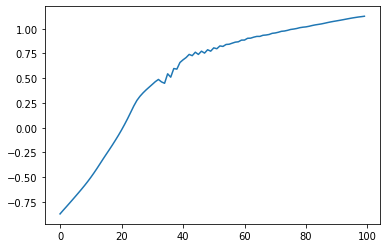

In [19]:
plt.plot(np.arange(n_epoch), -train_loss / len(X_train), label='Train Loss')

In [20]:
pred_weights, pred_means, pred_std = evaluate([tf.nn.softmax(logits), locs, scales])


In [21]:
#### THIS IS NOT WORKING RN ######

evaluate(tf.global_variables_initializer())


log_likelihood_train = y.log_prob(y_train)
log_likelihood_train = -tf.reduce_sum(log_likelihood_train)
# learning_rate = 5e-2
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(log_likelihood_train)

log_likelihood_test = y.log_prob(y_test)
log_likelihood_test = -tf.reduce_sum(log_likelihood_test)
train_op = optimizer.minimize(log_likelihood_test)

##################################################################


evaluate(tf.global_variables_initializer())

#
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
    print("epoch: ", i)
    _, loss_value = evaluate([train_op, log_likelihood_train])
    train_loss[i] = loss_value
    
    _, loss_value_test = evaluate([train_op, log_likelihood_test])
    test_loss[i] = loss_value_test
    
    
###################################################################
## Plot log likelihood or loss

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(n_epoch), -test_loss / len(X_test), label='Test')
plt.plot(np.arange(n_epoch), -train_loss / len(X_train), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.show()



ValueError: Dimensions must be equal, but are 500 and 8000 for 'Normal/log_prob_2/standardize/sub' (op: 'Sub') with input shapes: [500], [8000].

In [22]:
### THIS ISNT WORKING RN ######

#################################################

# FailedPreconditionError
###### .  Everything works with y_train, x_train
#### including validation is rather difficult
#### 






# pred_weights, pred_means, pred_std = sess.run()

X_ph = tf.placeholder(tf.float32, [None, D])
pred_weights, pred_means, pred_std = sess.run([tf.nn.softmax(logits), locs, scales], feed_dict={X_ph: X_test})



#################### testing ####################

X_ph_new = tf.placeholder(tf.float32, [None, D])
locs_new, scales_new, logits_new = neural_network(X_ph_new)

pred_weights, pred_means, pred_std = sess.run([tf.nn.softmax(logits_new), locs_new, scales_new], feed_dict={X_ph_new: X_test})
# FailedPreconditionError




FailedPreconditionError: Attempting to use uninitialized value dense_8/kernel
	 [[node dense_8/kernel/read (defined at <ipython-input-12-3698e1d3c507>:50) ]]

Caused by op 'dense_8/kernel/read', defined at:
  File "/anaconda3/envs/tf_tfp/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-950065c9d2ff>", line 25, in <module>
    locs_new, scales_new, logits_new = neural_network(X_ph_new)
  File "<ipython-input-12-3698e1d3c507>", line 50, in neural_network
    scales = tf.layers.dense(net, K, activation=tf.exp)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/layers/core.py", line 188, in dense
    return layer.apply(inputs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1227, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 530, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 538, in __call__
    self._maybe_build(inputs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1603, in _maybe_build
    self.build(input_shapes)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py", line 949, in build
    trainable=True)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 435, in add_weight
    getter=vs.get_variable)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 349, in add_weight
    aggregation=aggregation)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/training/checkpointable/base.py", line 607, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1479, in get_variable
    aggregation=aggregation)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1220, in get_variable
    aggregation=aggregation)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 547, in get_variable
    aggregation=aggregation)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 499, in _true_getter
    aggregation=aggregation)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 911, in _get_single_variable
    aggregation=aggregation)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1395, in __init__
    constraint=constraint)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1557, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 81, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3890, in identity
    "Identity", input=input, name=name)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value dense_8/kernel
	 [[node dense_8/kernel/read (defined at <ipython-input-12-3698e1d3c507>:50) ]]


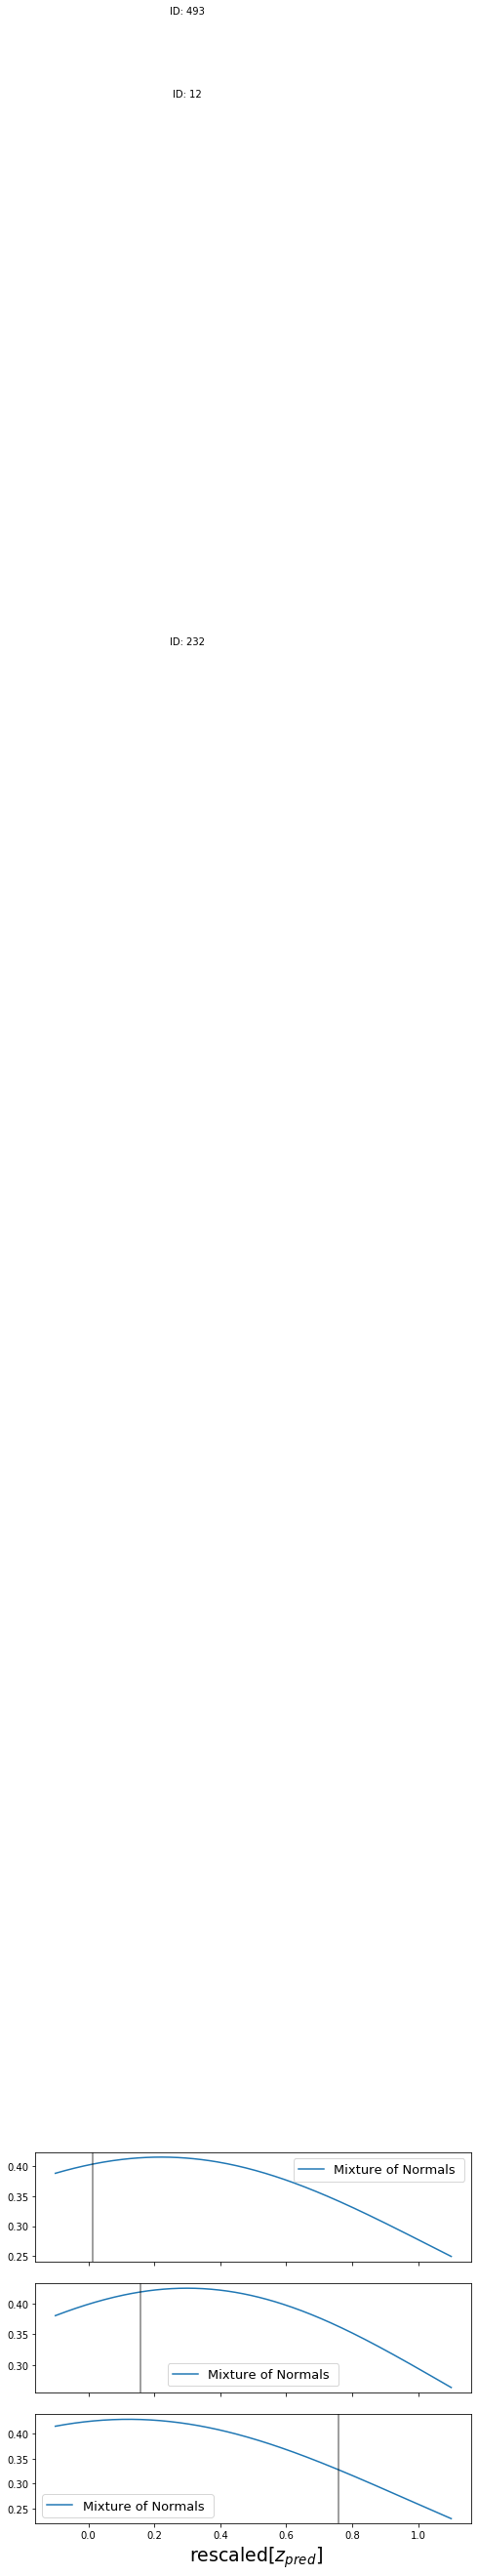

In [23]:



obj = [493, 12, 232]
fig, axes = plt.subplots(nrows=3, ncols=1, sharex = True, figsize=(8, 7))

plot_normal_mix(pred_weights[obj][0], pred_means[obj][0],
                pred_std[obj][0], axes[0], comp=False)
# axes[0].axvline(x=y_test[obj][0], color='black', alpha=0.5)
axes[0].axvline(x=y_train[obj][0], color='black', alpha=0.5)

axes[0].text(0.3, 4.0, 'ID: ' +str(obj[0]), horizontalalignment='center',
             verticalalignment='center')


plot_normal_mix(pred_weights[obj][1], pred_means[obj][1],
                pred_std[obj][1], axes[1], comp=False)
# axes[1].axvline(x=y_test[obj][1], color='black', alpha=0.5)
axes[1].axvline(x=y_train[obj][1], color='black', alpha=0.5)

axes[1].text(0.3, 4.0, 'ID: ' +str(obj[1]), horizontalalignment='center',
             verticalalignment='center')

plot_normal_mix(pred_weights[obj][2], pred_means[obj][2],
                pred_std[obj][2], axes[2], comp=False)
# axes[2].axvline(x=y_test[obj][2], color='black', alpha=0.5)
axes[2].axvline(x=y_train[obj][2], color='black', alpha=0.5)

axes[2].text(0.3, 4.0, 'ID: ' +str(obj[2]), horizontalalignment='center',
             verticalalignment='center')

plt.xlabel(r' rescaled[$z_{pred}]$', fontsize = 19)

plt.show()




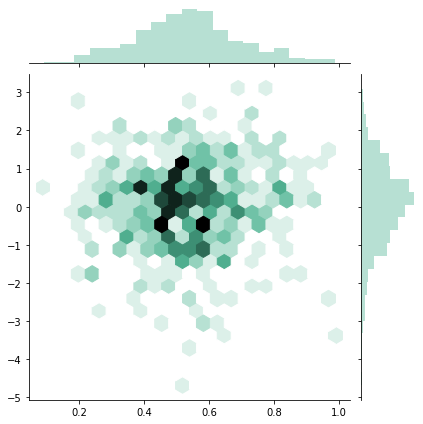

In [24]:



a = sample_from_mixture(X_test[:,1], pred_weights, pred_means,
                        pred_std, amount=len(X_test))
sns.jointplot(a[:, 0], a[:, 1], kind="hex", color="#4CB391")
plt.show()




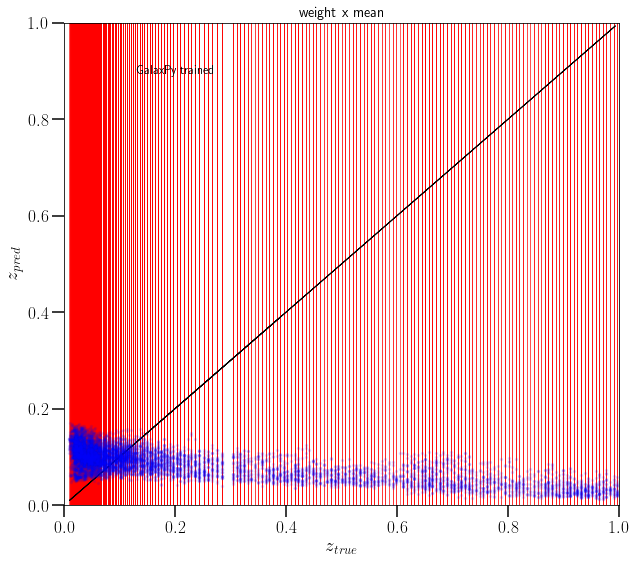

In [26]:

#############################################################################3

import SetPub
SetPub.set_pub()


## Overall mean --- weight * mean

y_pred = np.sum(pred_means*pred_weights, axis = 1)
y_pred_std = np.sum(pred_std*pred_weights, axis = 1)

plt.figure(22, figsize=(9,8))


# plt.scatter(y_test, y_pred, facecolors='k', s = 1)
# plt.errorbar( (ymax - ymin)*(ymin + y_train), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(ymin + y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)

plt.errorbar( ((ymax - ymin)*ymin + y_train), ((ymax - ymin)*ymin + y_pred), yerr= ((ymax - ymin)*ymin + y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)

plt.text(0.2, 0.9, train_datafile + ' trained', horizontalalignment='center', verticalalignment='center')
plt.plot((ymax - ymin)*(ymin + y_train), (ymax - ymin)*(ymin + y_train), 'k')
plt.ylabel(r'$z_{pred}$', fontsize = 19)
plt.xlabel(r'$z_{true}$', fontsize = 19)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('weight x mean')
plt.tight_layout()
plt.show()


###################################################################

Using TensorFlow backend.


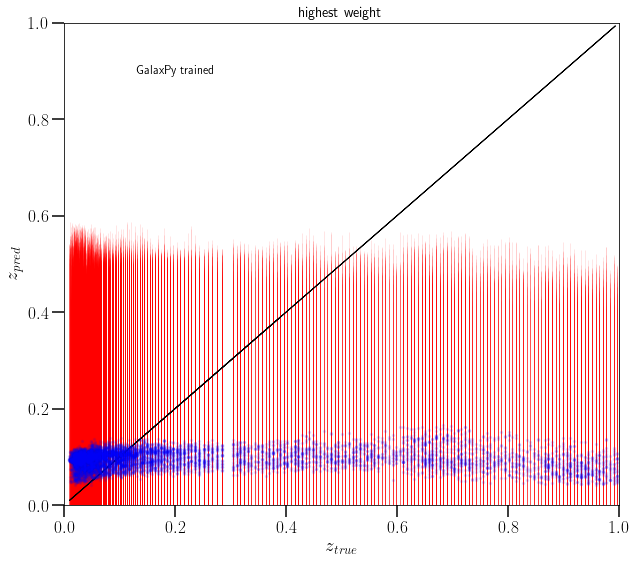

In [27]:

###########################################################################
##  mean --- highest weight



weight_max = np.argmax(pred_weights, axis = 1)  ## argmax or max???
weight_max = np.max(pred_weights, axis = 1)  ## argmax or max???
from keras.utils import np_utils
weight_max = np_utils.to_categorical(weight_max)


y_pred = np.max(pred_weights*weight_max*pred_means, axis=1)
y_pred_std = np.max(pred_weights*weight_max*pred_std, axis = 1)

# y_pred = pred_weights[weight_max]*pred_means[weight_max]
# y_pred_std = pred_weights[weight_max]*pred_std[weight_max]

plt.figure(24, figsize=(9, 8))


# plt.scatter(y_test, y_pred, facecolors='k', s = 1)
plt.errorbar( ((ymax - ymin)*ymin + y_train), ((ymax - ymin)*ymin + y_pred), yerr= ((ymax - ymin)*ymin + y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)


plt.text(0.2, 0.9, train_datafile + ' trained', horizontalalignment='center', verticalalignment='center')
plt.plot((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_test), 'k')
plt.ylabel(r'$z_{pred}$', fontsize = 19)
plt.xlabel(r'$z_{true}$', fontsize = 19)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('highest weight')
plt.tight_layout()
plt.show()


###################################################################

In [28]:
# weight_max = np.argmax(pred_weights, axis = 1)  ## argmax or max???
component_max = np.argmax(pred_weights/np.sqrt(2*np.pi*(pred_std**2)), axis = 1)  ## argmax or max???
# weight_max = np.max(pred_weights, axis = 1)  ## argmax or max???
component_max = np.max(pred_weights/np.sqrt(2*np.pi*(pred_std**2)), axis = 1)  ## argmax or max???
from keras.utils import np_utils
component_max = np_utils.to_categorical(component_max)

np.shape(component_max)

(8000, 1)

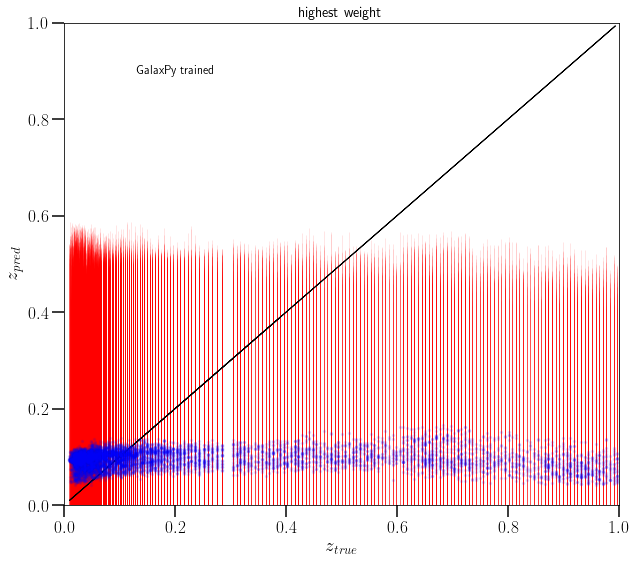

In [34]:

###########################################################################
##  peak

# weight_max = np.argmax(pred_weights, axis = 1)  ## argmax or max???
# component_argmax = np.argmax(pred_weights/np.sqrt(2*np.pi*(pred_std**2)), axis = 1)  ## argmax or max???
# weight_max = np.max(pred_weights, axis = 1)  ## argmax or max???
component_max = np.max(pred_weights/np.sqrt(2*np.pi*(pred_std**2)), axis = 1)  ## argmax or max???
from keras.utils import np_utils
component_max = np_utils.to_categorical(component_max)


y_pred = np.max(pred_weights*component_max*pred_means, axis=1)
y_pred_std = np.max(pred_weights*component_max*pred_std, axis = 1)

# y_pred = pred_weights[component_argmax]*pred_means[component_argmax]
# y_pred_std = pred_weights[component_argmax]*pred_std[component_argmax]

plt.figure(24, figsize=(9, 8))


# plt.scatter(y_test, y_pred, facecolors='k', s = 1)
plt.errorbar( ((ymax - ymin)*ymin + y_train), ((ymax - ymin)*ymin + y_pred), yerr= ((ymax - ymin)*ymin + y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)


plt.text(0.2, 0.9, train_datafile + ' trained', horizontalalignment='center', verticalalignment='center')
plt.plot((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_test), 'k')
plt.ylabel(r'$z_{pred}$', fontsize = 19)
plt.xlabel(r'$z_{true}$', fontsize = 19)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('highest weight')
plt.tight_layout()
plt.show()


###################################################################

In [35]:
y_pred_std = pred_weights[component_argmax]*pred_std[component_argmax]
y_pred_std.shape

(8000, 3)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

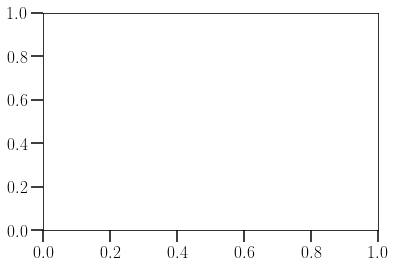

In [36]:

#############################################################################3

import SetPub
SetPub.set_pub()


## Overall mean --- weight * mean

y_pred = np.sum(pred_means*pred_weights, axis = 1)
y_pred_std = np.sum(pred_std*pred_weights, axis = 1)

plt.figure(22)


# plt.scatter(y_test, y_pred, facecolors='k', s = 1)
# plt.errorbar( (ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(ymin + y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)

plt.errorbar( (ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(ymin + y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)



plt.text(0.8, 2.0, datafile, horizontalalignment='center', verticalalignment='center')
plt.plot((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_test), 'k')
plt.ylabel(r'$z_{pred}$', fontsize = 19)
plt.xlabel(r'$z_{true}$', fontsize = 19)
# plt.xscale([0,1])
# plt.yscale([0,1])
plt.title('weight x mean')
plt.tight_layout()
plt.show()

###########################################################################
##  mean --- highest weight



weight_max = np.argmax(pred_weights, axis = 1)  ## argmax or max???
weight_max = np.max(pred_weights, axis = 1)  ## argmax or max???
from keras.utils import np_utils
weight_max = np_utils.to_categorical(weight_max)


y_pred = np.max(pred_weights*weight_max*pred_means, axis=1)
y_pred_std = np.max(pred_weights*weight_max*pred_std, axis = 1)

# y_pred = pred_weights[weight_max]*pred_means[weight_max]
# y_pred_std = pred_weights[weight_max]*pred_std[weight_max]

plt.figure(24)


# plt.scatter(y_test, y_pred, facecolors='k', s = 1)
plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
  ymin + y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)


plt.text(0.8, 2.0, datafile, horizontalalignment='center', verticalalignment='center')
plt.plot((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_test), 'k')
plt.ylabel(r'$z_{pred}$', fontsize = 19)
plt.xlabel(r'$z_{true}$', fontsize = 19)
# plt.xscale([0,1])a
# plt.yscale([0,1])
plt.title('highest weight')
plt.tight_layout()
plt.show()


###################################################################
###################################################################

In [38]:

########## SAVE sess ###########

#
#
#
# with tf.Session() as sess:
#     saver = tf.train.Saver()
#     sess.run(tf.global_variables_initializer())
#     saver.restore(sess, 'model-1')
#


saver = tf.train.Saver()
# sess_save = ed.get_session()


save_path = saver.save(sess, ModelName)
print("Inference model saved in file: %s" % save_path)



###################################################################
###################################################################

FailedPreconditionError: Attempting to use uninitialized value beta1_power_1
	 [[node save_1/SaveV2 (defined at <ipython-input-38-a0a96f5672cc>:14) ]]

Caused by op 'save_1/SaveV2', defined at:
  File "/anaconda3/envs/tf_tfp/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-a0a96f5672cc>", line 14, in <module>
    saver = tf.train.Saver()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 832, in __init__
    self.build()
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 844, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 881, in _build
    build_save=build_save, build_restore=build_restore)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 510, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 210, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 124, in save_op
    tensors)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1807, in save_v2
    name=name)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/anaconda3/envs/tf_tfp/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value beta1_power_1
	 [[node save_1/SaveV2 (defined at <ipython-input-38-a0a96f5672cc>:14) ]]


In [39]:
print(ModelName + '.meta')

./Model/Edward_posterior_cutsomLoss_GalaxPy_nComp3_ntrain8000_nepoch100_lr0.005_sim_obs_combine.meta


In [40]:

with tf.Session() as sess_load:
  new_saver = tf.train.import_meta_graph(ModelName + '.meta')
#   new_saver.restore(sess, tf.train.latest_checkpoint('./'))
  new_saver.restore(sess_load, ModelName)
  print('Model restored')


OSError: File ./Model/Edward_posterior_cutsomLoss_GalaxPy_nComp3_ntrain8000_nepoch100_lr0.005_sim_obs_combine.meta does not exist.

In [ ]:
# # https://github.com/tensorflow/probability/issues/325
# # from tensorflow.contrib.saved_model import save_keras_model


# #  To save:
# file = h5py.File('models/{}.h5'.format(model_name), 'w')
# weight = model.get_weights()
# for i in range(len(weight)):
#    file.create_dataset('weight' + str(i), data=weight[i])
# file.close()



# file = h5py.File('models/{}.h5'.format(model_name), 'r')
# weight = []
# for i in range(len(file.keys())):
#    weight.append(file['weight' + str(i)][:])
# model.set_weights(weight)

In [ ]:
### some progress here:: managed to restore the model
X_ph_new = tf.placeholder(tf.float32, [None, D])
y_ph_new = tf.placeholder(tf.float32, [None])
locs_new, scales_new, logits_new = neural_network(tf.convert_to_tensor(X_test))

cat_new = tfd.Categorical(logits=logits_new)
components_new = [tfd.Normal(loc=loc, scale=scale) for loc, scale
              in zip(tf.unstack(tf.transpose(locs_new)),
                     tf.unstack(tf.transpose(scales_new)))]

y_new = tfd.Mixture(cat=cat_new, components=components_new)



sess_load = tf.Session() 
new_saver = tf.train.import_meta_graph(ModelName + '.meta')
#   new_saver.restore(sess, tf.train.latest_checkpoint('./'))
new_saver.restore(sess_load, ModelName)
print('Model restored')

# print(sess_load.run('w1:0'))


### works until here #######


def neural_network(X):
    """
    loc, scale, logits = NN(x; theta)

    Args:
      X: Input Tensor containing input data for the MDN
    Returns:
      locs: The means of the normal distributions that our data is divided into.
      scales: The scales of the normal distributions that our data is divided
        into.
      logits: The probabilities of ou categorical distribution that decides
        which normal distribution our data points most probably belong to.
    """
    # 2 hidden layers with 15 hidden units
    net = tf.layers.dense(X, 15, activation=tf.nn.relu)
    net = tf.layers.dense(net, 15, activation=tf.nn.relu)
    locs = tf.layers.dense(net, K, activation=None)
    scales = tf.layers.dense(net, K, activation=tf.exp)
    logits = tf.layers.dense(net, K, activation=None)
    return locs, scales, logits


# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())

# locs, scales, logits = neural_network(tf.convert_to_tensor(X_test))




print('good so far')


pred_weights_new, pred_means_new, pred_std_new = sess_load.run(
            [tf.nn.softmax(logits_new), locs_new, scales_new], feed_dict={X_ph_new: X_test})



In [ ]:
x_test = np.expand_dims(X_test[idx], axis=0)

y_test_prob = []
feed_dict = {x: x_test, n: 1}
for i in range(n_samples):
  y_test_prob.append(sess.run(probs, feed_dict=feed_dict))

y_test_prob = np.squeeze(np.array(y_test_prob))

In [ ]:


ifTesting = False
if ifTesting:
##########  TESTING SCRIPT ################


    X_ph_new = tf.placeholder(tf.float32, [None, D])
    y_ph_new = tf.placeholder(tf.float32, [None])


    def neural_network(X):
      """loc, scale, logits = NN(x; theta)"""
      # 2 hidden layers with 15 hidden units
      net = tf.layers.dense(X, 15, activation=tf.nn.relu)
      net = tf.layers.dense(net, 15, activation=tf.nn.relu)
      locs = tf.layers.dense(net, K, activation=None)
      scales = tf.layers.dense(net, K, activation=tf.exp)
      logits = tf.layers.dense(net, K, activation=None)
      return locs, scales, logits


    locs_new, scales_new, logits_new = neural_network(X_ph_new)

    cat_new = ed.Categorical(logits=logits_new)
    components_new = [ed.Normal(loc=loc, scale=scale) for loc, scale
                  in zip(tf.unstack(tf.transpose(locs_new)),
                         tf.unstack(tf.transpose(scales_new)))]
    y_new = ed.Mixture(cat=cat_new, components=components_new, value=tf.zeros_like(y_ph_new))
    ## Note: A bug exists in Mixture which prevents samples from it to have
    ## a shape of [None]. For now fix it using the value argument, as
    ## sampling is not necessary for MAP estimation anyways.

    ######################### inference ##############################

    # There are no latent variables to infer. Thus inference is concerned
    # with only training model parameters, which are baked into how we
    # specify the neural networks.



    inference_new = ed.MAP(data={y_new: y_ph_new})
    optimizer_new = tf.train.AdamOptimizer(learning_rate=learning_rate)
    inference.initialize(optimizer=optimizer_new, var_list=tf.trainable_variables())


    # new_saver = tf.train.Saver()
    new_saver = tf.train.import_meta_graph(ModelName+'.meta')

    sess_load = ed.get_session()
    # tf.global_variables_initializer().run()


    # ModelName = './Model/Edward_posterior'
    # new_saver = tf.train.Saver()

    new_saver.restore(sess_load, ModelName)
    print("Model restored.")


    pred_weights_new, pred_means_new, pred_std_new = sess_load.run(
        [tf.nn.softmax(logits_new), locs_new, scales_new], feed_dict={X_ph_new: X_test})





    obj = [93, 402, 120]
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex = True, figsize=(8, 7))

    plot_normal_mix(pred_weights_new[obj][0], pred_means_new[obj][0],
                    pred_std_new[obj][0], axes[0], comp=False)
    axes[0].axvline(x=y_test[obj][0], color='black', alpha=0.5)
    axes[0].text(0.3, 4.0, 'ID: ' +str(obj[0]), horizontalalignment='center',
                 verticalalignment='center')


    plot_normal_mix(pred_weights_new[obj][1], pred_means_new[obj][1],
                    pred_std_new[obj][1], axes[1], comp=False)
    axes[1].axvline(x=y_test[obj][1], color='black', alpha=0.5)
    axes[1].text(0.3, 4.0, 'ID: ' +str(obj[1]), horizontalalignment='center',
                 verticalalignment='center')

    plot_normal_mix(pred_weights_new[obj][2], pred_means_new[obj][2],
                    pred_std_new[obj][2], axes[2], comp=False)
    axes[2].axvline(x=y_test[obj][2], color='black', alpha=0.5)
    axes[2].text(0.3, 4.0, 'ID: ' +str(obj[2]), horizontalalignment='center',
                 verticalalignment='center')

    plt.xlabel(r' rescaled[$z_{pred}]$', fontsize = 19)

    plt.show()

